# About this notebook
In this notebook, I will be working on using Bayesian statistics tools on modelling the 2008 election poll results. The problem as stated in "Bayesian Data Analysis" is as follows:
The file `pew_research_center_june_elect_wknd_data.dta3` has data from Pew Research Center polls taken during the 2008 election campaign. You can read these data into R using the `read.dta()` function (after first loading the foreign package into R).
Your task is to estimate the percentage of the (adult) population in each state (excluding Alaska, Hawaii, and the District of Columbia) who label themselves as ‘very liberal,’ following the general procedure that was used in Section 2.7 to estimate cancer rates, but using the binomial and beta rather than Poisson and gamma distributions. But you do not need to make maps; it will be enough to make scatterplots, plotting the estimate vs. Barack Obama’s vote share in 2008 (data available at `2008ElectionResult.csv`, readable in R using `read.csv()`).
Make the following four graphs on a single page:
- Graph proportion very liberal among the survey respondents in each state vs. Obama vote share—that is, a scatterplot using the two-letter state abbreviations (see state.abb() in R).
- Graph the Bayes posterior mean in each state vs. Obama vote share.
- Repeat graphs (a) and (b) using the number of respondents in the state on the x-axis.


This exercise has four challenges: 
- first, manipulating the data in order to get the totals by state
- second, estimating the parameters of the prior distribution
- third, doing the Bayesian analysis by state
- fourth, making the graphs.


In [1]:
import numpy as np 
import pandas as pd 
import scipy.stats as ss 
import matplotlib.pyplot as plt 

import pymc as pm 
import arviz as az 

In [2]:
df = pd.read_stata('./pew_research_center_june_elect_wknd_data.dta')
df = df[['state', 'party']] 

df.head()

,state,party
0,massachusetts,democrat
1,massachusetts,republican
2,massachusetts,independent
3,massachusetts,independent
4,massachusetts,democrat


In [20]:
votes = pd.read_csv('./2008ElectionResult.csv')

votes.head()

,state,vote_Obama,vote_Obama_pct,vote_McCain,vote_McCain_pct,electoral_vote_dem,electoral_vote_rep
0,Alabama,811764,38.8,1264879,60.4,NaN,9.0
1,Alaska,105650,37.7,168844,60.2,NaN,3.0
2,Arizona,948648,45.0,1132560,53.8,NaN,10.0
3,Arkansas,418049,38.8,632672,58.8,NaN,6.0
4,California,7245731,60.9,4434146,37.3,55.0,NaN


In [3]:
# modified from here: https://gist.github.com/rogerallen/1583593
state2abb = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
    "Washington Dc" : "DC"
}

In [4]:
df['state'] = df['state'].apply(lambda x, state2abb=state2abb : state2abb[x.title()])
df['party'] = df['party'].apply(lambda x : 1 if x == 'democrat' else 0)
df['party'] = (df['party'].fillna(0)
                          .astype(int))

df.head()

,state,party
0,MA,1
1,MA,0
2,MA,0
3,MA,0
4,MA,1


In [21]:
votes['state'] = votes['state'].apply(lambda x, state2abb=state2abb: state2abb[x])

votes.head()

,state,vote_Obama,vote_Obama_pct,vote_McCain,vote_McCain_pct,electoral_vote_dem,electoral_vote_rep
0,AL,811764,38.8,1264879,60.4,NaN,9.0
1,AK,105650,37.7,168844,60.2,NaN,3.0
2,AZ,948648,45.0,1132560,53.8,NaN,10.0
3,AR,418049,38.8,632672,58.8,NaN,6.0
4,CA,7245731,60.9,4434146,37.3,55.0,NaN


In [5]:
df1 = (df.groupby(by='state', as_index=False)
        .agg(count=('party', 'sum'),
             total=('party', 'count')))

df1.head()

,state,count,total
0,AL,175,624
1,AZ,142,542
2,AR,86,307
3,CA,1078,2854
4,CO,156,468


## Method 1: Using math/Bayes' theorem

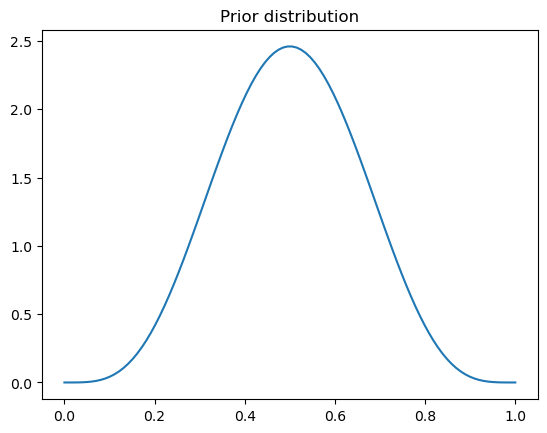

In [12]:
alpha = 5
beta = 5

prior = ss.beta(a=alpha, b=beta) 

xx = np.linspace(0, 1, 100)
yy = prior.pdf(xx) 

plt.plot(xx, yy)
plt.title('Prior distribution')
plt.show()

In [16]:
def get_posterior_mean(row : pd.Series, alpha : float, beta : float) -> float:
    N = row['total']
    y = row['count'] 

    new_alpha = alpha + y 
    new_beta = N - y + beta 
    posterior = ss.beta(a=new_alpha, b=new_beta) 
    return posterior.mean()

In [22]:
df1['posterior_mean1'] = df1.apply(get_posterior_mean, alpha=alpha, beta=beta, axis=1)

df1.head()

,state,count,total,posterior_mean1
0,AL,175,624,0.283912
1,AZ,142,542,0.266304
2,AR,86,307,0.287066
3,CA,1078,2854,0.378142
4,CO,156,468,0.336820


## Method 2: Using PyMC

In [57]:
state = 'CA'
count = df1.loc[df['state'] == state, 'count']
total = df1.loc[df['state'] == state, 'total']

model = pm.Model()

with model:
    p = pm.Beta(name='p', alpha=alpha, beta=beta)
    y = pm.Binomial(name='count', n=total, p=p, observed=count)

    idata = pm.sample(draws=1000, tune=2000, random_seed=3141596)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


In [58]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

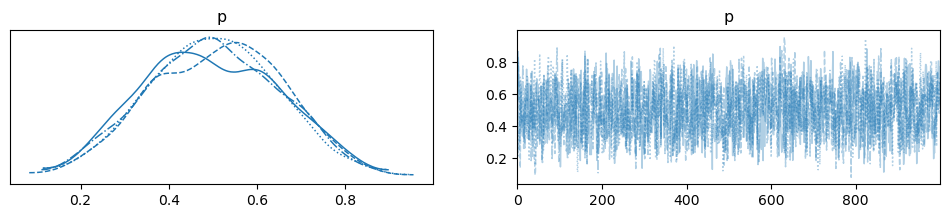

In [59]:
az.plot_trace(idata, var_names=["p"])
plt.show()

In [60]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.502,0.151,0.23,0.782,0.004,0.003,1718.767,2802.222,1.004


In [69]:
idata.posterior['p'].to_numpy()

array([[0.55360351, 0.79744388, 0.86712732, ..., 0.72190259, 0.66869927,
        0.76895972],
       [0.46239289, 0.28543327, 0.21546783, ..., 0.53591696, 0.53591696,
        0.58547206],
       [0.45795099, 0.45795099, 0.83699718, ..., 0.48216815, 0.66804354,
        0.57398105],
       [0.59028649, 0.29929202, 0.79566832, ..., 0.54289717, 0.62754059,
        0.70961285]])

In [71]:
def get_posterior_mean2(row : pd.Series, alpha : float, beta : float) -> float:
    N = row['total']
    y = row['count'] 

    model = pm.Model()

    with model:
        p = pm.Beta(name='p', alpha=alpha, beta=beta)
        count = pm.Binomial(name='count', n=N, p=p, observed=y)
        idata = pm.sample(draws=1000, tune=1000, progressbar=False)
    
    return idata.posterior['p'].to_numpy().mean()

In [74]:
import logging
logger = logging.getLogger('pymc')
logger.setLevel(logging.ERROR)

df1['posterior_mean2'] = df1.apply(get_posterior_mean2, alpha=alpha, beta=beta, axis=1)
df1.head()

,state,count,total,posterior_mean1,posterior_mean2
0,AL,175,624,0.283912,0.283878
1,AZ,142,542,0.266304,0.266735
2,AR,86,307,0.287066,0.287558
3,CA,1078,2854,0.378142,0.378377
4,CO,156,468,0.336820,0.336702


In [75]:
df2 = (pd.merge(left=df1, 
                right=votes,
                on='state',
                how='inner'))

df2.head()

,state,count,total,posterior_mean1,posterior_mean2,vote_Obama,vote_Obama_pct,vote_McCain,vote_McCain_pct,electoral_vote_dem,electoral_vote_rep
0,AL,175,624,0.283912,0.283878,811764,38.8,1264879,60.4,NaN,9.0
1,AZ,142,542,0.266304,0.266735,948648,45.0,1132560,53.8,NaN,10.0
2,AR,86,307,0.287066,0.287558,418049,38.8,632672,58.8,NaN,6.0
3,CA,1078,2854,0.378142,0.378377,7245731,60.9,4434146,37.3,55.0,NaN
4,CO,156,468,0.336820,0.336702,1216793,53.5,1020135,44.9,9.0,NaN


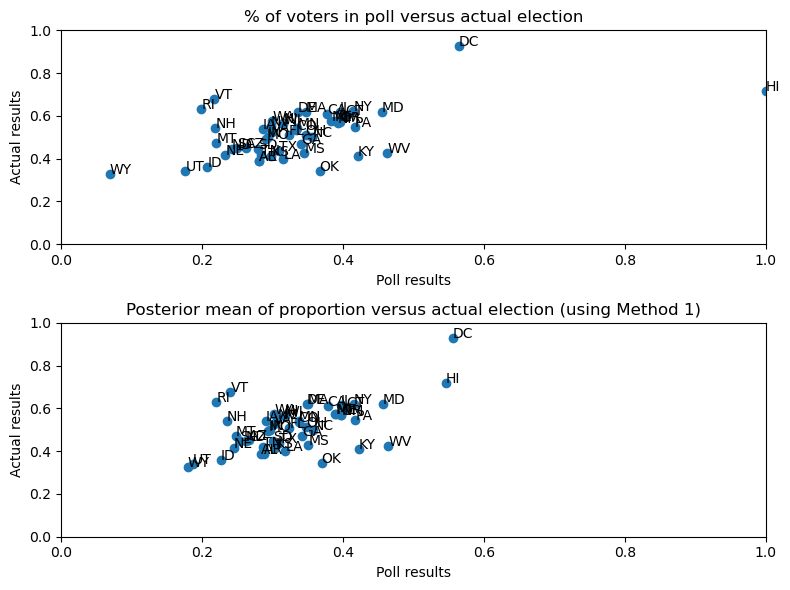

In [97]:
fig, axes = plt.subplots(2, 1, figsize=(8, 2 * 3))

axes[0].scatter(df2['count'] / df2['total'], 0.01 * df2['vote_Obama_pct'])
axes[1].scatter(df2['posterior_mean1'], 0.01 * df2['vote_Obama_pct'])

axes[0].set_title('% of voters in poll versus actual election')
axes[0].set_xlabel('Poll results')
axes[0].set_ylabel('Actual results')

axes[1].set_title('Posterior mean of proportion versus actual election (using Method 1)')
axes[1].set_xlabel('Poll results')
axes[1].set_ylabel('Actual results')


for i, st in enumerate(df2['state'].tolist()):
    axes[0].annotate(st, ((df2['count'] / df2['total']).loc[i], 0.01 * df2['vote_Obama_pct'].loc[i]))
    axes[1].annotate(st, (df2['posterior_mean1'].loc[i], 0.01 * df2['vote_Obama_pct'].loc[i]))

plt.setp(axes, xlim=[0, 1], ylim=[0, 1])
plt.tight_layout()
plt.show()

## Conclusion:
Certain states like Idaho (ID), Maryland (MD), Vermont (VT) had very equal proportions in the poll versus the elections, as opposed to DC or Hawaii (HI) and Wyoming (WY). Gotta watch out for those states!